In [1]:
import os
os.getcwd()

'/home/jovyan/ArditArifi'

In [2]:
source_path="/home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6"
output_path="/home/jovyan/student-storages/GROUP3/ArditArifi/output"

! mkdir -p output_path

Analysis

In [3]:
import glob
# ANALYSIS
import xarray as xr
import pandas as p
import numpy as np
# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
from scipy.stats import wilcoxon, norm
# USER 
import area_weight as aw


In [4]:

# REGIONS
region_label = ["ARC", "ANT"]
arctic_lat = [60, 90]
antarctic_lat = [-90, -60]

# SEASONS
seasons_label = ["DJF", "MAM", "JJA", "SON"]
seasons = {
    "DJF": [12, 1, 2],   # Dec, Jan, Feb
    "MAM": [3, 4, 5],    # Mar, Apr, May
    "JJA": [6, 7, 8],    # Jun, Jul, Aug
    "SON": [9, 10, 11],  # Sep, Oct, Nov
}

# Create combined region-season labels
region_season_label = [f"{region} {season}" for region in region_label for season in seasons_label]

# EXPERIMENTS
experiments = ["2xss", "2xdust", "2xfire", "2xDMS", "aer" ]

# MODELS
models = ["IPSL-CM6A-LR-INCA", "UKESM1-0-LL", "NorESM2-LM"]

# PATTERN FUNCTION
patter = lambda model, var, exp: f"{source_path}/{var}*{model}*-{exp}*.nc"

In [5]:
# CONSTRUCT TABLE
mean_values = np.full(
    shape=(len(region_season_label), len(experiments), len(models)),
    fill_value=np.nan
)
std_values = np.full(
    shape=(len(region_season_label), len(experiments), len(models)),
    fill_value=np.nan
)


# LOAD DATA
model = ""
var = "rtmt"
weight_function = aw.area_weight_cosine
alpha = 0.05

# Calculate total steps for progress
total_steps = len(models) * len(experiments) * len(seasons_label)
current_step = 0
# MAIN LOOP
for idx_model, model in enumerate(models):
    try:
        # Open control dataset for this model
        ds_ctl = xr.open_mfdataset(patter(model, var, "control"), combine="by_coords")
    except Exception as e:
        print(f"Error opening control files {patter(model, var, 'control')}: {e}")
        # Skip all seasons for this model if control is missing
        current_step += len(seasons_label) * len(experiments)
        continue
    
    for idx_exp, exp in enumerate(experiments):
        # Try opening the experiment dataset
        try:
            ds_exp = xr.open_mfdataset(patter(model, var, exp), combine="by_coords")
        except Exception as e:
            print(f"Error opening experiment files {patter(model, var, exp)}: {e}")
            current_step += len(seasons_label)
            continue

        # Compute bias as experiment minus control
        ds_bias = ds_exp[var] - ds_ctl[var]

        for idx_season, season in enumerate(seasons_label):
            # Increment progress
            current_step += 1
            pct = (current_step / total_steps) * 100
            print(f"Progress: {current_step}/{total_steps} -> {pct:.2f}%")

            # 1) Select months for this season
            ds_season = ds_bias.sel(time=ds_bias.time.dt.month.isin(seasons[season]))

            # ---------------------
            # ARCTIC
            # ---------------------
            ds_season_arctic = ds_season.sel(
                lat=slice(arctic_lat[0], arctic_lat[1]),
            )
            # First, take time mean (removes the 'time' dimension)
            ds_arctic_time_mean = ds_season_arctic.mean(dim="time")

            # Define weights after subsetting region
            weights_arctic_2d =aw.get_weights(weight_function, ds_season_arctic.lat.values , ds_season_arctic.lon.values  )
            # Now do the weighted mean/std over lat/lon
            arc_mean = ds_arctic_time_mean.weighted(weights_arctic_2d).mean(dim=("lat","lon")).values
            arc_std  = ds_arctic_time_mean.weighted(weights_arctic_2d).std(dim=("lat","lon")).values

            mean_values[idx_season, idx_exp, idx_model] = arc_mean
            std_values[idx_season, idx_exp, idx_model]  = norm.ppf(1-alpha) * arc_std / np.sqrt( ds_arctic_time_mean.size )
            
            # ---------------------
            # ANTARCTIC
            # ---------------------
            ds_season_antarctic = ds_season.sel(
                lat=slice(antarctic_lat[0], antarctic_lat[1]),
            )
            # Time mean first
            ds_antarctic_time_mean = ds_season_antarctic.mean(dim="time")

            # Define weights after subsetting region
            weights_antarctic_2d = aw.get_weights(weight_function, ds_season_antarctic.lat.values , ds_season_antarctic.lon.values  )

            ant_mean = ds_antarctic_time_mean.weighted(weights_antarctic_2d).mean(dim=("lat","lon")).values
            ant_std  = ds_antarctic_time_mean.weighted(weights_antarctic_2d).std(dim=("lat","lon")).values

            mean_values[idx_season + 4, idx_exp, idx_model] = ant_mean
            std_values[idx_season + 4, idx_exp, idx_model]  = norm.ppf(1-alpha) * ant_std / np.sqrt( ds_antarctic_time_mean.size )
            
# Finally, display the populated array
print("Shape of mean_values:", mean_values.shape)
print(mean_values)

Progress: 1/60 -> 1.67%
Progress: 2/60 -> 3.33%
Progress: 3/60 -> 5.00%
Progress: 4/60 -> 6.67%
Progress: 5/60 -> 8.33%
Progress: 6/60 -> 10.00%
Progress: 7/60 -> 11.67%
Progress: 8/60 -> 13.33%
Error opening experiment files /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/rtmt*IPSL-CM6A-LR-INCA*-2xfire*.nc: no files to open
Error opening experiment files /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/rtmt*IPSL-CM6A-LR-INCA*-2xDMS*.nc: no files to open
Progress: 17/60 -> 28.33%
Progress: 18/60 -> 30.00%
Progress: 19/60 -> 31.67%
Progress: 20/60 -> 33.33%
Progress: 21/60 -> 35.00%
Progress: 22/60 -> 36.67%
Progress: 23/60 -> 38.33%
Progress: 24/60 -> 40.00%
Progress: 25/60 -> 41.67%
Progress: 26/60 -> 43.33%
Progress: 27/60 -> 45.00%
Progress: 28/60 -> 46.67%
Progress: 29/60 -> 48.33%
Progress: 30/60 -> 50.00%
Progress: 31/60 -> 51.67%
Progress: 32/60 -> 53.33%
Progress: 33/60 -> 55.00%
Progress: 34/60 -> 56.67%
Progress: 35/60 -> 58.33%
Progress: 36/60 -> 60.00%
Progress: 37/60 ->

In [8]:
import pandas as pd
import numpy as np

# Example loops:
for exp_idx, exp_name in enumerate(experiments):
    # Create a MultiIndex for columns: (Model, ["mean", "std"])
    cols = pd.MultiIndex.from_product(
        [models, ["mean", "std"]], names=["model", "stat"]
    )
    
    # Create an empty DataFrame with row index = region_season_label
    df_exp = pd.DataFrame(index=region_season_label, columns=cols)
    
    # Fill the DataFrame with mean and std values
    for model_idx, model_name in enumerate(models):
        df_exp[(model_name, "mean")] = mean_values[:, exp_idx, model_idx]
        df_exp[(model_name, "std")]  = std_values[:, exp_idx, model_idx]
    
    # Print or save the DataFrame
    print(f"\nExperiment: {exp_name}")
    print(df_exp)


Experiment: 2xss
model   IPSL-CM6A-LR-INCA           UKESM1-0-LL           NorESM2-LM          
stat                 mean       std        mean       std       mean       std
ARC DJF          0.340372  0.020678   -0.630242  0.021025  -1.186079  0.030381
ARC MAM         -0.537149  0.029552    0.267529  0.018363  -0.332585  0.033507
ARC JJA         -0.953486  0.048664   -0.459772  0.027102  -0.606369  0.072451
ARC SON         -0.213423  0.016214   -0.164365  0.012117  -0.278196  0.024440
ANT DJF         -0.639208  0.029941   -0.696725  0.026232  -1.907187  0.094346
ANT MAM         -0.149330  0.016957   -0.341245  0.011610  -0.491165  0.023297
ANT JJA          0.025352  0.014866    0.166987  0.009058  -0.224593  0.022507
ANT SON         -0.049143  0.019846   -0.584054  0.016654  -1.136484  0.063189

Experiment: 2xdust
model   IPSL-CM6A-LR-INCA           UKESM1-0-LL           NorESM2-LM          
stat                 mean       std        mean       std       mean       std
ARC DJF       

In [12]:
import numpy as np
import pandas as pd

# 1) Compute ensemble mean (mean over models => axis=2)
#    Resulting shape = (n_region_season, n_experiments)
ensemble_mean = np.nanmean(mean_values, axis=2)

# 2) Convert to a pandas DataFrame
#    Rows = region/season labels, Columns = experiments
df_ensemble_mean = pd.DataFrame(
    ensemble_mean,
    index=region_season_label,  # region_season_label is your list of region-season combos
    columns=experiments
)

# 3) Print or save the DataFrame
print("Ensemble mean (per experiment & region/season):")
print(df_ensemble_mean)

Ensemble mean (per experiment & region/season):
             2xss    2xdust    2xfire     2xDMS       aer
ARC DJF -0.491983  0.054228  0.401043 -0.264381 -0.325764
ARC MAM -0.200735 -0.028606  1.429065 -0.382750 -0.962762
ARC JJA -0.673209 -0.114043  0.939526 -2.291285 -2.191357
ARC SON -0.218661  0.103131  0.118915 -0.191256 -0.078186
ANT DJF -1.081040 -0.066867  0.557679 -2.804782 -0.161180
ANT MAM -0.327246  0.249164 -0.118038 -0.225238 -0.114969
ANT JJA -0.010752  0.552422  0.093827  0.152515  0.187949
ANT SON -0.589894  0.428771  0.352736 -0.503456  0.014822


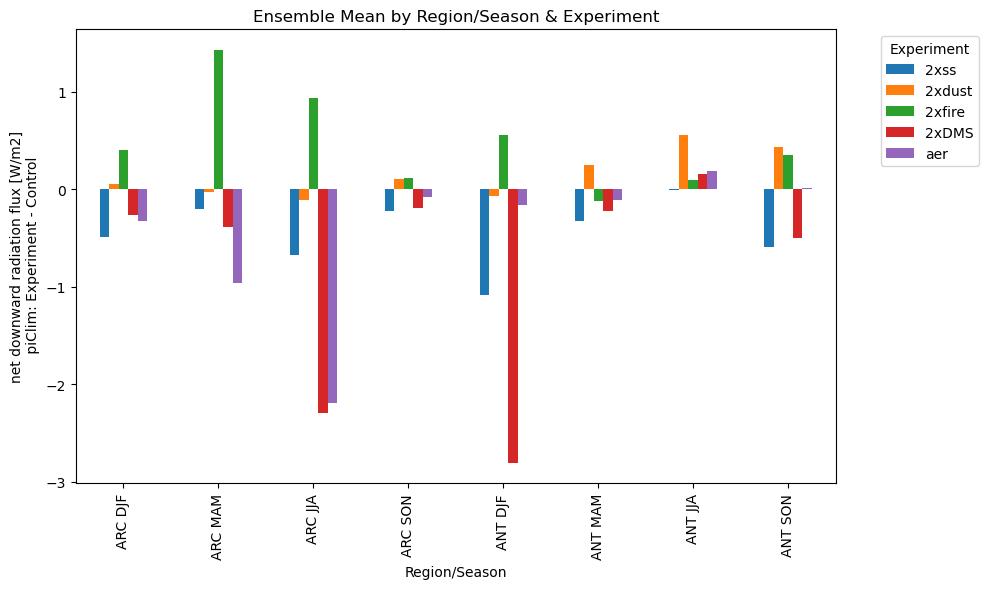

In [23]:
import matplotlib.pyplot as plt

# Basic bar chart where each row (region/season) is on the x-axis
# and each experiment is represented by a different color/group of bars
df_ensemble_mean.plot(
    kind='bar', 
    figsize=(10, 6), 
    title='Ensemble Mean by Region/Season & Experiment'
)

plt.xlabel('Region/Season')
plt.ylabel('net downward radiation flux [W/m2]\n piClim: Experiment - Control')
plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure (choose format and resolution)
plt.savefig("ensemble_mean_barplot.png", dpi=300)

plt.show()

